In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import Callback
import pandas as pd
import pickle 

In [8]:
file_path = 'D:/bla bla/exported_dataset_New.xlsx'
df = pd.read_excel(file_path)

In [9]:
# Prepare features (X) and labels (Y)
X = df.drop(['Max Rising Slope', 'Soak Time', 'Reflow Time', 'Peak Temp'], axis=1)  # Drop target columns from features
Y = df[['Peak Temp']]  # Multi-output labels

In [10]:
# Initialize MinMaxScaler
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

In [11]:
# Scale the features and labels
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

In [12]:
# Save the **fitted** scalers using pickle after fitting (not the scaled data)
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open('scaler_Y.pkl', 'wb') as f:
    pickle.dump(scaler_Y, f)

In [6]:
# Split the dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.1, random_state=42)

In [7]:
# Define the custom callback to track R² score
class R2ScoreCallback(Callback):
    def __init__(self, X_val, Y_val):
        self.X_val = X_val
        self.Y_val = Y_val
        self.r2_scores = []

    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.X_val)  # Predict on validation set
        predictions = scaler_Y.inverse_transform(predictions)  # Inverse transform predictions
        Y_val_original = scaler_Y.inverse_transform(self.Y_val)  # Inverse transform actual values
        r2 = r2_score(Y_val_original, predictions)  # Calculate R² score
        self.r2_scores.append(r2)  # Save R² score
        print(f"Epoch {epoch+1}: R² score = {r2}")

In [8]:
# Instantiate the R² score callback
r2_callback = R2ScoreCallback(X_test, Y_test)

In [9]:
model = Sequential()

# Layer 0: 96 units, Tanh activation, 0.4 dropout
model.add(Dense(96, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))

# Layer 1: 352 units, Tanh activation, 0.2 dropout
model.add(Dense(352, activation='tanh'))
model.add(Dropout(0.2))

# Output layer for regression (1 output unit)
model.add(Dense(1))

In [10]:
# Compile the model with Adam optimizer and the specified learning rate
optimizer = Adam(learning_rate=0.0033354971021203267)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [11]:
# Train the model and track history and R² score
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test),callbacks=[r2_callback])

Epoch 1/100

1/1 [==============================] - 0s 115ms/step
Epoch 1: R² score = -0.3782720676515625
9/9 [==============================] - 2s 65ms/step - loss: 0.4060 - val_loss: 0.0409
Epoch 2/100
1/1 [==============================] - 0s 44ms/stepss: 0.07
Epoch 2: R² score = -0.47401751951276205
9/9 [==============================] - 0s 21ms/step - loss: 0.0663 - val_loss: 0.0438
Epoch 3/100
1/1 [==============================] - 0s 31ms/stepss: 0.05
Epoch 3: R² score = 0.10544913957325486
9/9 [==============================] - 0s 20ms/step - loss: 0.0510 - val_loss: 0.0266
Epoch 4/100
1/1 [==============================] - 0s 45ms/stepss: 0.03
Epoch 4: R² score = 0.6104791746400643
9/9 [==============================] - 0s 21ms/step - loss: 0.0390 - val_loss: 0.0116
Epoch 5/100
1/1 [==============================] - 0s 40ms/stepss: 0.02
Epoch 5: R² score = 0.6805304718394607
9/9 [==============================] - 0s 21ms/step - loss: 0.0277 - val_loss: 0.0095
Epoch 6/100
1/1 [

In [12]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, Y_test)
print(f'Test loss: {loss}')

1/1 [==============================] - 0s 82ms/step - loss: 0.0072
Test loss: 0.007204064633697271


In [13]:
# Make predictions on the test set
predictions_scaled = model.predict(X_test)

1/1 [==============================] - 0s 37ms/step


In [14]:
# Inverse transform the predictions and actual values to get them back to the original scale
predictions = scaler_Y.inverse_transform(predictions_scaled)
Y_test_original = scaler_Y.inverse_transform(Y_test)

In [15]:
# Print a few predictions and actual values in their original (unscaled) form
for i in range(20):
    print(f"Predicted: {predictions[i]}, Actual: {Y_test_original[i]}")

Predicted: [241.83022], Actual: [240.95]
Predicted: [239.15097], Actual: [235.75]
Predicted: [217.70699], Actual: [216.42]
Predicted: [239.4792], Actual: [241.45]
Predicted: [218.881], Actual: [220.75]
Predicted: [238.61275], Actual: [239.77]
Predicted: [238.65378], Actual: [246.69]
Predicted: [238.60114], Actual: [234.51]
Predicted: [238.82718], Actual: [239.78]
Predicted: [237.784], Actual: [242.72]
Predicted: [239.20029], Actual: [236.4]
Predicted: [238.1062], Actual: [241.02]
Predicted: [240.03473], Actual: [249.31]
Predicted: [239.66624], Actual: [244.43]
Predicted: [238.96614], Actual: [239.51]
Predicted: [238.16577], Actual: [239.06]
Predicted: [239.79666], Actual: [240.95]
Predicted: [236.37184], Actual: [236.69]
Predicted: [240.0091], Actual: [241.02]
Predicted: [238.87743], Actual: [243.6]


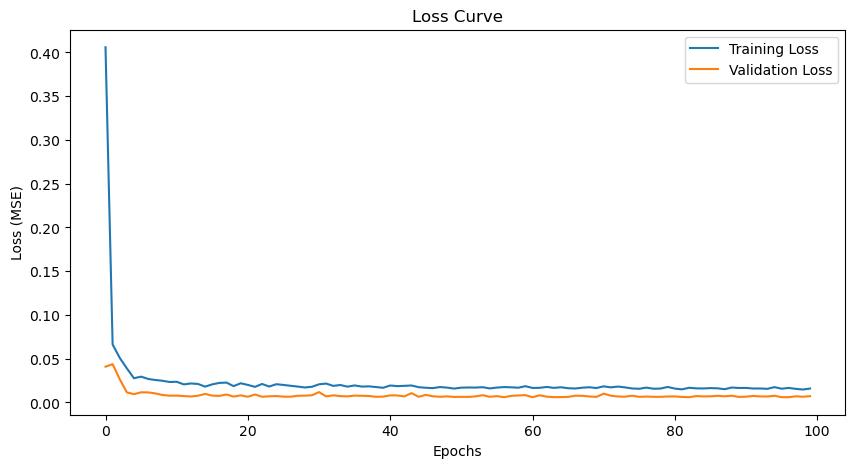

In [16]:
# Plot the loss curve (training and validation)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

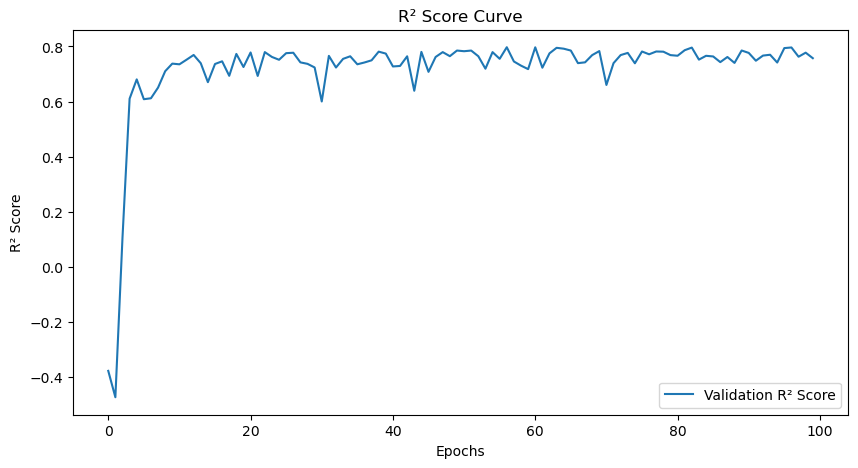

In [17]:
# Plot the R² score curve for validation set
plt.figure(figsize=(10, 5))
plt.plot(r2_callback.r2_scores, label='Validation R² Score')
plt.title('R² Score Curve')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.show()

In [18]:
# Save the trained model to a file
model_save_path = 'D:/aaaaaa/Soak_Time.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to D:/aaaaaa/Soak_Time.h5
